In [1]:
using PyPlot
using JuMP, Ipopt

In [2]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");

# Optimizating the Global Climate Action Policy Portfolio

#### Physical Climate Model Parameters

In [3]:
# Model domain
dt = 10. # year timestep
t = Array(2020:dt:2200);

CO₂_init = 460.
δT_init = 1.1

ECS = 3.0; # "Best-guess equilibrium climate sensitivity"

ocean_fraction = 0.71
H = 4000. * ocean_fraction; # effective depth of deep ocean [m]
ρ = 1000.; # density of liquid water [kg m^-3]
Cp = 4180.0; # specific heat capacity of liquid  water [J kg^-1 K^-1]
Cd = Cp * ρ * H # upper ocean heat capacity

τd = 200. # deep ocean relaxation time scale [years] (similar to Gregory 2000, Held 2009)
κ = Cd / τd
r = 0.4;

physics = Physics(ECS, CO₂_init, δT_init, Cd, κ, r);

#### Economic parameters

Assume damages of 2% of global world product (GWP) for 3$^{\circ}$C of warming (similar to DICE damage function).

In [4]:
GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.0 # ρ (relative low value from Stern review)

# Control technology cost scales, as fraction of GWP (cost scale is for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.05*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

#### No-policy baseline scenario

We begin with a reference no-policy baseline scenario in which CO2 concentrations increase at a rate determined by the emissions rate $q(t)$, which here a constant $q_{0} = 5$ ppm/year (second argument of `baseline_emissions()` function) until 2060 (third argument), at which point emissions are assumed to decrease to zero over the next 40 years (fourth argument).

All of these parameters are easily modified in the `baseline_emissions()` function below.

In [5]:
baseline_emissions_scenario = baseline_emissions(t, 15., 2100., 2140.)

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    1. /6., 0., 0., nothing, # Assumed initial condition of zero control deployments in 2020
    baseline_emissions_scenario
);

### Initialize model

In [6]:
ensemble = Dict{String, ClimateModel}();

name = "Example configuration";
present_year = 2020.

# Arbitrary initial guess of climate control policies, to be optimized later!
controls = init_zero_controls(t);

# Create instance of idealized integrated assessment climate model
model = ClimateModel(name, t, dt, present_year, economics, physics, controls,);

# Calculate and print the social cost of carbon (defined by the
# climate damages due to an extra metric ton of CO2 emitted in 2020)
print(string("Social cost of carbon: \$", SCC(model)))

Social cost of carbon: $15.52

## Model optimization

We now calculate the optimal trajectories of climate control deployments $\alpha$ by minimizing an objective function (also known as a "cost function") under a set of physical and policy constraints. The physical constraints are that the fractional deployments of climate controls are between 0 (no deployment) and 1 (full deployment). The policy constraints are that the climate controls begin at 0 fraction deployment in 2020 and that deployments can only change at a maximum rate of $\partial \alpha \, / \, \partial t < 1/30$ (i.e. from zero to full deployment in 30 years).

The model currently supports three optimizations options, representing different assumed cost functions or additional policy constraints:
- `temp` (default): in this scenario, the model finds the lowest total discounted cost of climate controls which results in temperatures that remain below a specified temperature goal. The temperature goal is given as an additional parameter in degrees Celsius, e.g. `optimize_controls!(model, maxslope = maxslope, obj_option = "temp", temp_goal = 2.0)`.

- `net_cost`: in this scenario, the model optimizes the total net discounted cost of handling climate change, including both the direct costs $\beta \, \delta T_{\alpha}^{2} \, (1 - \chi)$ of (controlled) damages from climate impacts and the costs $\sum C_{\alpha}f(\alpha)$ of deploying climate controls.

- `budget`: in this scenario, the model finds the combination of discounted climate control investments which, given a specified budget, provides the lowest (controlled) damages from cimate impacts. The budget is given as an additional parameter in trillions of USD, e.g. `optimize_controls!(model, maxslope = maxslope, obj_option = "budget", budget = 10.)`.

In [7]:
m = optimize_controls!(
    model,
    obj_option = "temp",
    temp_goal = 2.0,
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



### Plotting the optimal solution state

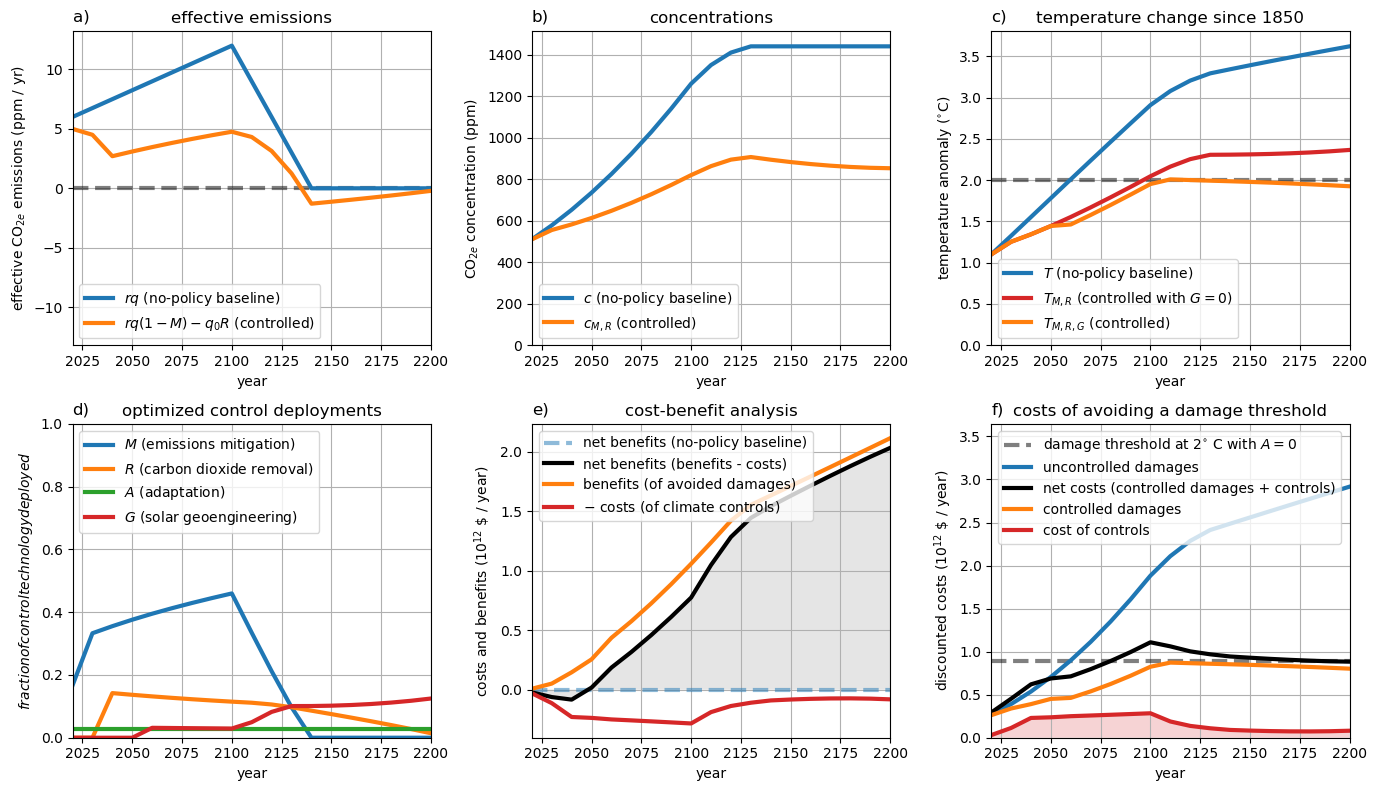

In [8]:
plot_state(model)
savefig("../figures/default_configuration.png", bbox_inches="tight", dpi=100)